In [160]:
import numpy as np
import math
from copy import deepcopy
import sklearn.datasets
from sklearn.svm import SVC
from matplotlib import pyplot as plt

In [145]:
X,y = sklearn.datasets.make_hastie_10_2()
X_train = X[0:8000,:]
y_train = y[0:8000]
X_test = X[8000:,:]
y_test = y[8000:]

# Exercise 1
Implement the AdaBoost ensemble algorithm by completing the following code:

In [146]:
# Implementazione di SVC che permette l'uso di pesi normalizzati
class SVC_:
    def __init__(self, kernel="rbf", degree="3"):
        self.svc = SVC(kernel=kernel, degree=degree)

    def fit(self, X,y,sample_weight=None):
        if sample_weight is not None:
            sample_weight = sample_weight * len(X)

        self.svc.fit(X,y,sample_weight=sample_weight)
        return self

    def predict(self, X):
        return self.svc.predict(X)

In [147]:
def calc_error(y_true, y_pred):
    return 0.5 - ((np.dot(y_true.T, y_pred)) / (2 * len(y_true)))

In [200]:
class AdaBoost:
    def __init__(self, weakModel, T, step = 10):
        self.T = T
        self.model = weakModel
        self.alphas = []
        self.models = []
        self.weight_err = []
        self.partial_err = []
        self.step = step

    def fit(self, X, y):
        w = self.__init_weights(y.size)
        partial_pred = np.zeros(y.size)
        
        for t in range(self.T):
            model, y_pred = self.__apply_weak_model(X,y,w)
                                
            ymt = y * y_pred
            error = np.dot(w, (ymt < 0).astype(int))
            assert error <= 0.5, "Error is not < 0.5: %f" % error
        
            alpha = 0.5 * np.log((1 - error) / error)
            
            w = w * np.exp(-alpha * ymt)
            w = w / np.sum(w)
            
            self.alphas.append(alpha)
            self.models.append(model)
            partial_pred += alpha * y_pred
            partial_error = calc_error(y, np.sign(partial_pred))
            
            self.weight_err.append(error)
            self.partial_err.append(partial_error)
            
            if (t == 0) or (t % self.step == 0):
                print("Iterazione: {} \t\t Errore pesato: {} \t\t Errore ensemble: {}".format(t, error, partial_error))
            
        return self

    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for t in range(self.T):
            a = self.alphas[t]
            m = self.models[t]
            preds += a * m.predict(X)
        return np.sign(preds)
    
    def __init_weights(self, n):
        return np.ones(n)/n
    
    def __apply_weak_model(self, X, y, w):
        mt = deepcopy(self.model)
        return mt.fit(X,y,sample_weight=w), mt.predict(X)
        

In the implementation you are free to assume:
- that the problem is a binary classification problem with labels in $\{-1, +1\}$.
- that the weakModel can fit a weighted sample set by means of the call `weakModel.fit(X,y,sample_weight=w)` where `w` is a vector of length $|y|$.

Test your implementation on the dataset loaded above and using an SVC with a polynomial kernel. 

In [203]:
weakModel = SVC_(kernel="poly", degree=3)
adaboost = AdaBoost(weakModel, 100)
adaboost.fit(X_train, y_train)
y_pred_train = adaboost.predict(X_train)
y_pred_test = adaboost.predict(X_test)

print("\nErrore di classificazione su training set: {}".format(calc_error(y_train, y_pred_train)))
print("Errore di classificazione su test set: {}".format(calc_error(y_pred, y_pred_test)))

Iterazione: 0 		 Errore pesato: 0.3490000000000002 		 Errore ensemble: 0.349
Iterazione: 10 		 Errore pesato: 0.382590275872082 		 Errore ensemble: 0.21425
Iterazione: 20 		 Errore pesato: 0.4075128824730465 		 Errore ensemble: 0.172875
Iterazione: 30 		 Errore pesato: 0.4265847419371456 		 Errore ensemble: 0.16675
Iterazione: 40 		 Errore pesato: 0.4377559859328395 		 Errore ensemble: 0.16025
Iterazione: 50 		 Errore pesato: 0.4363473302222514 		 Errore ensemble: 0.15250000000000002
Iterazione: 60 		 Errore pesato: 0.4562050567739646 		 Errore ensemble: 0.14137499999999997
Iterazione: 70 		 Errore pesato: 0.4311152367121065 		 Errore ensemble: 0.14250000000000002
Iterazione: 80 		 Errore pesato: 0.4575246560844142 		 Errore ensemble: 0.130625
Iterazione: 90 		 Errore pesato: 0.46165177829218673 		 Errore ensemble: 0.130125

Errore di classificazione su training set: 0.126125
Errore di classificazione su test set: 0.0


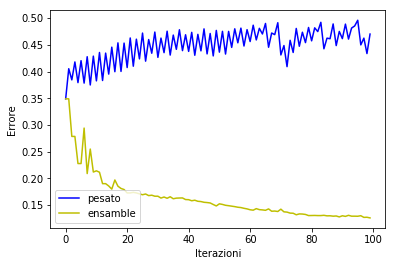

In [204]:
xs = np.arange(0, len(adaboost.partial_err))
plt.plot(xs, adaboost.weight_err, "b")
plt.plot(xs, adaboost.partial_err, "y")
plt.xlabel("Iterazioni")
plt.ylabel("Errore")
plt.legend(['pesato', 'ensamble'], loc='lower left') 
plt.show()

and evaluate the AdaBoost performances as usual by calculating the classification error. 

**Note 1**:  
since the labels are bound to be in ${+1, -1}$, the classification error can be easily computed as:
$$
   error(y,y') = \frac{1}{2} - \frac{y^T \times y'}{2N},
$$
where $N$ is the total number of examples. The formula can be derived noticing that $y^T \times y'$ calculates the number $N_c$ of examples correctly classified  minus the number $N_{\bar c}$ of examples incorrectly classified. We have then $y^T \times y' = N_c - N_{\bar c}$ and by noticing that $N = N_c + N_{\bar c}$:
$$
   N - y^T \times y' = 2 N_{\bar c} \Rightarrow \frac{N - y^T \times y'}{2 N} = \frac{N_{\bar c}}{N} = error(y,y')
$$

**Note 2**:
do not forget to deepcopy your base model before fitting it to the new data

**Note 3**:
The SVC model allows specifying weights, but it *does not* work well when weights are normalized (it works well when the weights are larger). The following class takes normalized weights and denormalize them before passing them to the SVC classifier:

```python
    class SVC_:
        def __init__(self, kernel="rbf", degree="3"):
            self.svc = SVC(kernel=kernel, degree=degree)

        def fit(self, X,y,sample_weight=None):
            if sample_weight is not None:
                sample_weight = sample_weight * len(X)

            self.svc.fit(X,y,sample_weight=sample_weight)
            return self

        def predict(self, X):
            return self.svc.predict(X)
```

# Exercise 2

Write a weak learner to be used with the AdaBoost algorithm you just wrote. The weak learner that you will implement shall work as follows:

- creates a random linear model $y(x) = \mathbf{w} \cdot \mathbf{x} + t$ by generating the needed weight vector $\mathbf{w}$ and $t$ at random; each weight shall be sampled from U(-1,1);
- it evaluates the weighted loss $\epsilon_t$ on the given dataset and flip the linear model if $\epsilon_t > 0.5$
- at prediction time it predicts +1 if $\mathbf{x} \cdot \mathbf{w} > 0$ it predicts -1 otherwise.

In [193]:
class RandomLinearModel:
    
    def __init__(self):
        self.flip = 1
        
    def loss(self, y, y_, w):
        return np.dot(w, ((y*y_) < 0).astype(int))
        
    def fit(self,X,y,sample_weight=None):
        self.w = np.random.uniform(-1, 1, X.shape[1])
        err = self.loss(y, self.predict(X), sample_weight)
        if err >= 0.5: self.flip = -1
        return self        
        
    def predict(self,X):
        return np.sign(np.dot(X, self.w) * self.flip)

Learn an AdaBoost model using the RandomLinearModel weak learner printing every $K$ iterations the weighted error and the current error of the ensemble (you are free to choose $K$ so to make your output just frequent enough to let you know what is happening but without flooding the console with messages). Evaluate the training and test error of the final ensemble model.

In [201]:
rs = RandomLinearModel()
a = AdaBoost(rs, 10000, step=500)
a.fit(X_train,y_train)

y_pred_train = a.predict(X_train)
y_pred_test = a.predict(X_test)

print("\nErrore di classificazione su training set: {}".format(calc_error(y_train, y_pred_train)))
print("Errore di classificazione su test set: {}".format(calc_error(y_pred, y_pred_test)))

Iterazione: 0 		 Errore pesato: 0.49575000000000036 		 Errore ensemble: 0.49575
Iterazione: 500 		 Errore pesato: 0.49828099800615094 		 Errore ensemble: 0.426125
Iterazione: 1000 		 Errore pesato: 0.49764947942235527 		 Errore ensemble: 0.396625
Iterazione: 1500 		 Errore pesato: 0.4992429826692379 		 Errore ensemble: 0.370625
Iterazione: 2000 		 Errore pesato: 0.4997816176597797 		 Errore ensemble: 0.357
Iterazione: 2500 		 Errore pesato: 0.4977914931768004 		 Errore ensemble: 0.3395
Iterazione: 3000 		 Errore pesato: 0.49872729256786397 		 Errore ensemble: 0.32925
Iterazione: 3500 		 Errore pesato: 0.49856675365811187 		 Errore ensemble: 0.3185
Iterazione: 4000 		 Errore pesato: 0.4987455647272179 		 Errore ensemble: 0.3075
Iterazione: 4500 		 Errore pesato: 0.49956886476639195 		 Errore ensemble: 0.29874999999999996
Iterazione: 5000 		 Errore pesato: 0.4916183948491171 		 Errore ensemble: 0.286625
Iterazione: 5500 		 Errore pesato: 0.49432255164051864 		 Errore ensemble: 0.273875
I

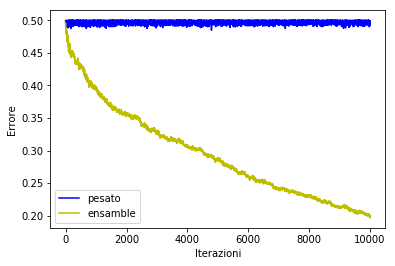

In [202]:
xs = np.arange(0, len(a.partial_err))
plt.plot(xs, a.weight_err, "b")
plt.plot(xs, a.partial_err, "y")
plt.xlabel("Iterazioni")
plt.ylabel("Errore")
plt.legend(['pesato', 'ensamble'], loc='lower left') 
plt.show()

Write few paragraphs about what you think about the experiment and about the results you obtained. 

Come si può osservare dai test la procedura di boosting permette di ridurre l'errore di classificazione apprendendo un insieme di modelli utilizzando un algoritmo di apprendimento debole e "costringendolo", tramite i pesi, a classificare bene parte degli esempi che ha difficoltà a classificare.

### Test \#1
Utilizzando come weak learner il Support Vector Classifier si nota una decrescita esponenziale dell'errore all'aumentare del numero delle iterazioni. La procedura di boosting permette di ridurre l'errore a piacimento in poche iterazioni.

### Test \#2
Utilizzando come weak learner il RandomLinearModel la procedura ensamble permette comunque di migliorare l'errore, ma a fronte di un numero di iterazioni molto maggiore, si nota infatti che l'errore decresce molto più lentamente rispetto al modello ensable che utilizza come weak learne il SVC.

Le differenze tra i due test potrebbero essere causate dal modo in cui operano i weak learner.
La SVC cerca il miglior separatore basandosi sugli esempi del training set e cercando di ottimizzare i pesi ad ogni iterazione. Il modello lineare invece genera i pesi in maniera casuale e di conseguenza il separatore (diverso ad ogni iterazione) risulta più impreciso e commette un errore vicino al 50% ad ogni iterazione. Ciò richiede un numero maggiore di iterazioni per far sì che l'errore decresca a sufficienza.